In [5]:
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import lightkurve as lk
from chromo import eb
from chromo.utils import background_correct

In [73]:
tic = 'TIC 55404385'

In [74]:
raw_tpf = lk.search_tesscut(tic).download(cutout_size=[30, 30], quality_bitmask=None)

/Users/ch/K2/repos/lightkurve/lightkurve/search.py:144: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


In [75]:
lc = background_correct(raw_tpf).to_lightcurve()
lc.targetid = tic
lc.label = tic

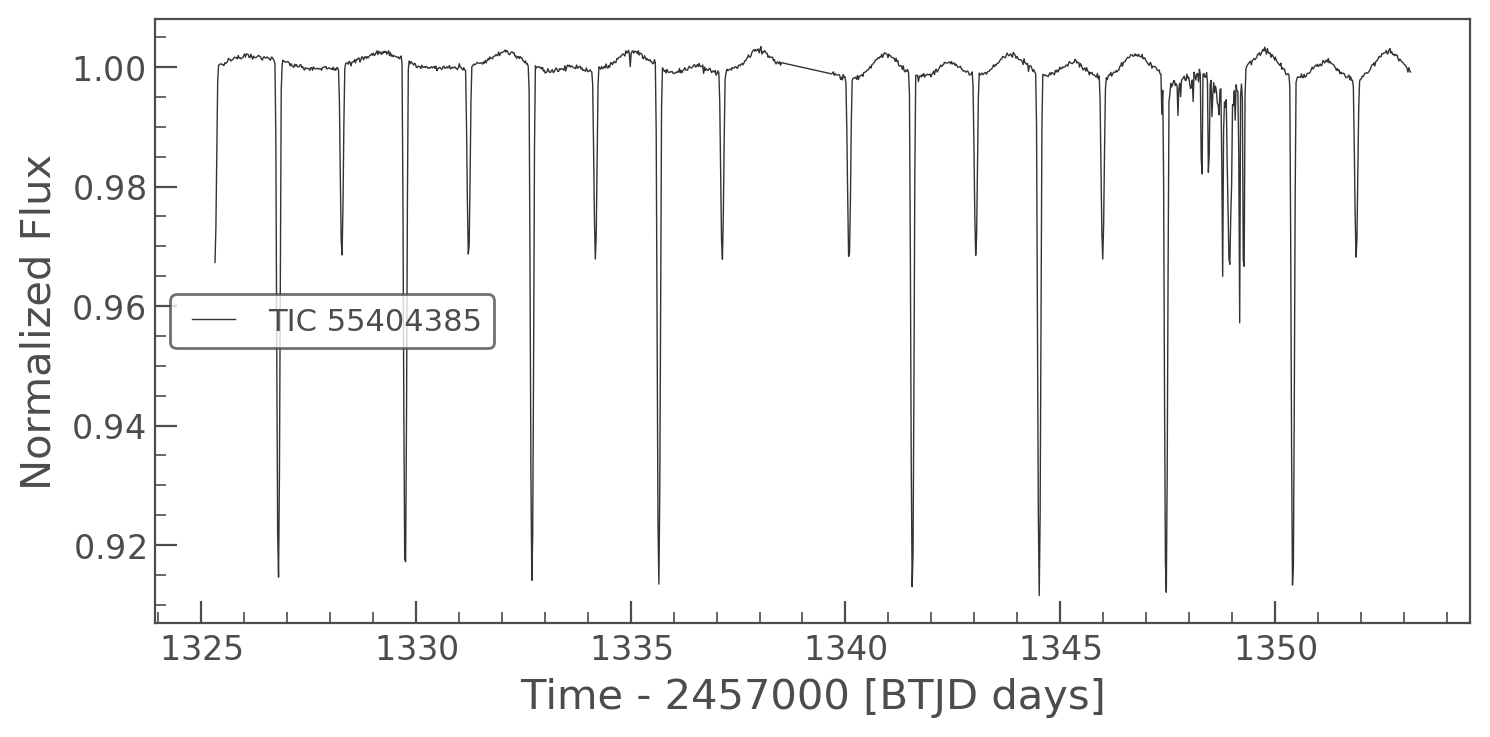

In [76]:
lc.plot()

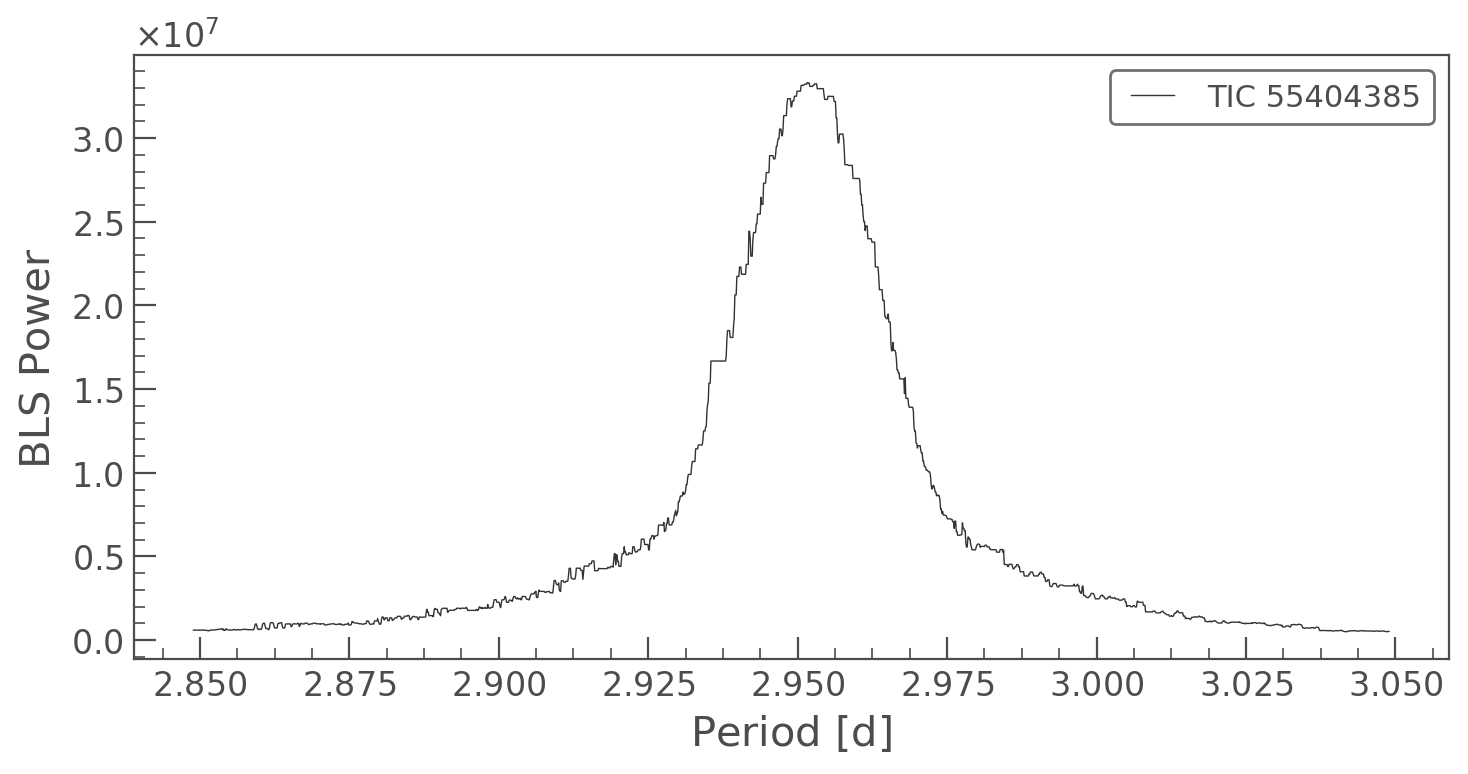

In [78]:
p = lc.to_periodogram('bls', duration=0.1, minimum_period=1, maximum_period=20)
period = p.period_at_max_power.value
p = lc.to_periodogram('bls', duration=0.1, minimum_period=period-0.1, maximum_period=period+0.1, frequency_factor=0.1)
p.plot()

In [80]:
period, t0 = p.period_at_max_power.value, p.transit_time_at_max_power

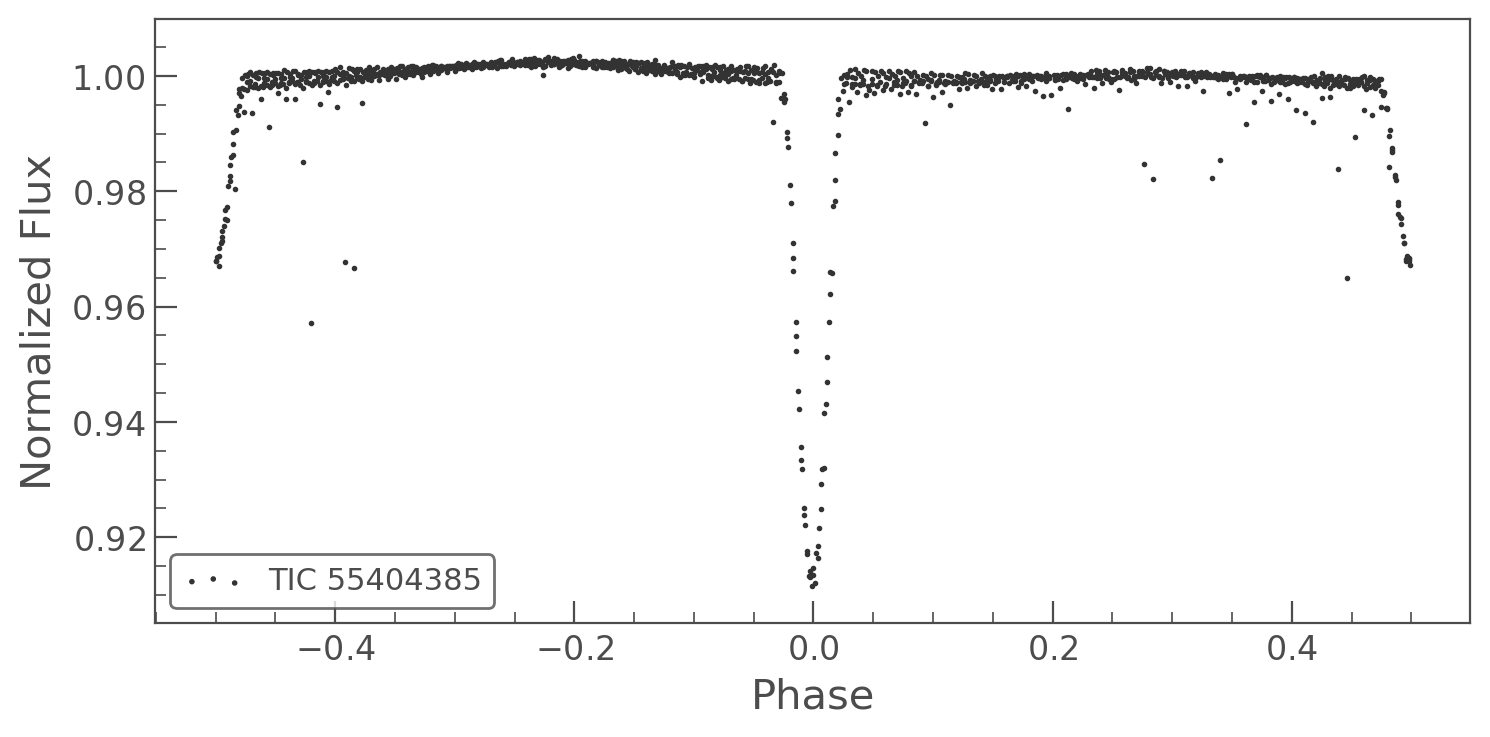

In [81]:
f = lc.fold(period, t0).scatter()

In [ ]:
eb.analyze(raw_tpf, period, t0, name=tic)